In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

### **Step 2: Data Preparation**
You need a dataset containing labeled images of brain tumors. For demonstration, assume the data is organized as follows:
```
dataset/
  train/
    tumor/
    no_tumor/
  validation/
    tumor/
    no_tumor/
```

Use `ImageDataGenerator` to preprocess the images:
```python

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source directories
tumor_src = r'C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\yes'
no_tumor_src = r'C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\no'

# Define target directories for training and validation
base_dir = r'C:\Users\user\Desktop\archive (1)\brain_tumor_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Create directories for train and validation
os.makedirs(os.path.join(train_dir, 'tumor'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'no_tumor'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'tumor'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'no_tumor'), exist_ok=True)

# Get list of files in each category
tumor_files = os.listdir(tumor_src)
no_tumor_files = os.listdir(no_tumor_src)

# Split files into 80% training and 20% validation
tumor_train, tumor_val = train_test_split(tumor_files, test_size=0.2, random_state=42)
no_tumor_train, no_tumor_val = train_test_split(no_tumor_files, test_size=0.2, random_state=42)

# Move tumor images
for file in tumor_train:
    shutil.move(os.path.join(tumor_src, file), os.path.join(train_dir, 'tumor', file))
for file in tumor_val:
    shutil.move(os.path.join(tumor_src, file), os.path.join(validation_dir, 'tumor', file))

# Move no_tumor images
for file in no_tumor_train:
    shutil.move(os.path.join(no_tumor_src, file), os.path.join(train_dir, 'no_tumor', file))
for file in no_tumor_val:
    shutil.move(os.path.join(no_tumor_src, file), os.path.join(validation_dir, 'no_tumor', file))

print("Dataset organized successfully!")


Dataset organized successfully!


In [6]:
# Verify number of images in each folder
for root, dirs, files in os.walk(base_dir):
    print(f"Directory: {root}, Number of files: {len(files)}")

Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset, Number of files: 0
Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\no, Number of files: 0
Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\train, Number of files: 0
Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\train\no_tumor, Number of files: 78
Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\train\tumor, Number of files: 124
Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\validation, Number of files: 0
Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\validation\no_tumor, Number of files: 20
Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\validation\tumor, Number of files: 31
Directory: C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\yes, Number of files: 0


In [7]:
train_dir = r'C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\train'
validation_dir = r'C:\Users\user\Desktop\archive (1)\brain_tumor_dataset\validation'

In [8]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescaling for the validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

# Generating the datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for more than 2 classes
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [10]:
# Load the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Use softmax for more than 2 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multiclass
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5877 - loss: 0.7861 - val_accuracy: 0.6250 - val_loss: 0.6406
Epoch 2/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6875 - loss: 0.5687

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.6875 - loss: 0.5687 - val_accuracy: 0.6562 - val_loss: 0.5662
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6479 - loss: 0.6122 - val_accuracy: 0.7500 - val_loss: 0.5812
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.7500 - loss: 0.4965 - val_accuracy: 0.7500 - val_loss: 0.5600
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7508 - loss: 0.5444 - val_accuracy: 0.8125 - val_loss: 0.4571
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.7188 - loss: 0.5708 - val_accuracy: 0.7812 - val_loss: 0.4819
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7496 - loss: 0.4943 - val_accuracy: 0.7812 - val_loss: 0.5191
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.8438 - loss: 0.4230 - val_accuracy: 0.8125 - val_loss: 0.4793
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8152 - loss: 0.4615 - val_accuracy: 0.6875 - val_loss: 0.4830
Epoch 10/10
6/6

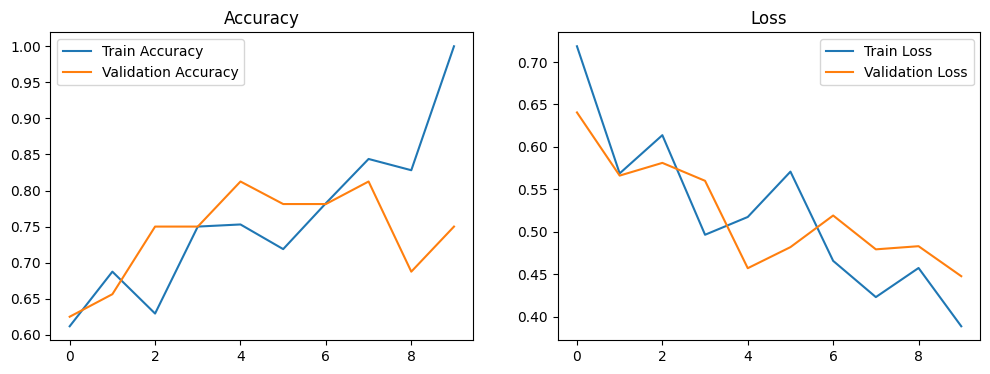

In [13]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [14]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7989 - loss: 0.4166 - val_accuracy: 0.7188 - val_loss: 0.5660
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.7500 - loss: 0.5844 - val_accuracy: 0.7188 - val_loss: 0.5119
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8007 - loss: 0.4182 - val_accuracy: 0.6562 - val_loss: 0.6310
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7812 - loss: 0.5302 - val_accuracy: 0.6250 - val_loss: 0.6852
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7495 - loss: 0.4694 - val_accuracy: 0.5312 - val_loss: 0.8584


In [15]:
model.save('brain_tumor_classifier_mobilenet.h5')

In [27]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = tf.keras.models.load_model('brain_tumor_classifier_mobilenet.h5')

def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Tumor"
    else:
        return "No Tumor"

result = predict_image('C:\Users\user\Desktop\archive(1)\brain_tumor_dataset\train\tumor.jpg')
print(f"Prediction: {result}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (48851642.py, line 15)